# Time Series Forcasting using LSTM

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
# Running Model for 100 epochs to find the optimum learning rate

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

E:\InstallationDir\Anaconda\envs\ml-ai\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
31/31 [==============================] - 10s 39ms/step - loss: 21.5167 - mae: 22.0115 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 21.1522 - mae: 21.6444 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 20.7302 - mae: 21.2236 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 20.2834 - mae: 20.7757 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 19.7897 - mae: 20.2855 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 19.1782 - mae: 19.6696 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 18.2410 - mae: 18.7333 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 12ms/step - loss: 17.4825 - mae: 17.9748 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 12ms/step - loss: 17.1597 - mae

Epoch 73/100
31/31 [==============================] - 0s 11ms/step - loss: 6.6376 - mae: 7.1196 - lr: 3.9811e-05
Epoch 74/100
31/31 [==============================] - 0s 12ms/step - loss: 5.6977 - mae: 6.1785 - lr: 4.4668e-05
Epoch 75/100
31/31 [==============================] - 0s 12ms/step - loss: 5.1889 - mae: 5.6658 - lr: 5.0119e-05
Epoch 76/100
31/31 [==============================] - 0s 11ms/step - loss: 5.1695 - mae: 5.6483 - lr: 5.6234e-05
Epoch 77/100
31/31 [==============================] - 0s 11ms/step - loss: 6.8937 - mae: 7.3783 - lr: 6.3096e-05
Epoch 78/100
31/31 [==============================] - 0s 13ms/step - loss: 6.3444 - mae: 6.8314 - lr: 7.0795e-05
Epoch 79/100
31/31 [==============================] - 0s 11ms/step - loss: 5.4018 - mae: 5.8814 - lr: 7.9433e-05
Epoch 80/100
31/31 [==============================] - 0s 10ms/step - loss: 5.1118 - mae: 5.5896 - lr: 8.9125e-05
Epoch 81/100
31/31 [==============================] - 0s 10ms/step - loss: 7.7439 - mae: 8.2296 

(1e-08, 0.0001, 0.0, 30.0)

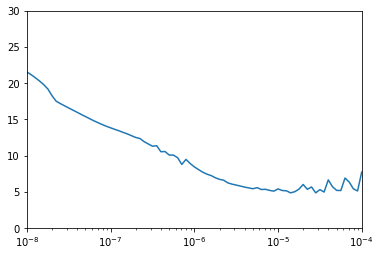

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

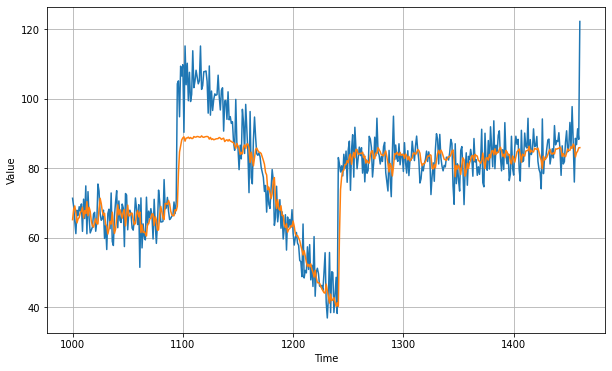

In [7]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.674914

<Figure size 432x288 with 0 Axes>

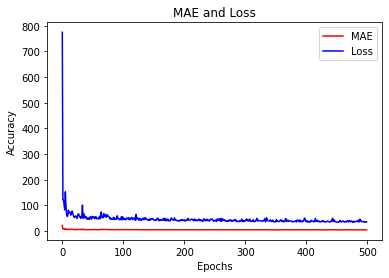

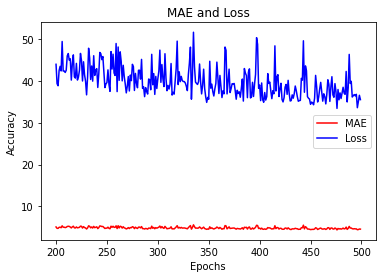

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [10]:
#Running model with 3 LSTM Layers.But first finding the optimum LR

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=0)

E:\InstallationDir\Anaconda\envs\ml-ai\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [11]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 10s 19ms/step - loss: 707.9825
Epoch 2/100
31/31 [==============================] - 1s 16ms/step - loss: 103.9582
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 81.5493
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 73.3897
Epoch 5/100
31/31 [==============================] - 1s 17ms/step - loss: 69.4884
Epoch 6/100
31/31 [==============================] - 1s 16ms/step - loss: 68.7573
Epoch 7/100
31/31 [==============================] - 1s 16ms/step - loss: 68.4195
Epoch 8/100
31/31 [==============================] - 1s 15ms/step - loss: 66.5901
Epoch 9/100
31/31 [==============================] - 1s 15ms/step - loss: 60.0927
Epoch 10/100
31/31 [==============================] - 0s 14ms/step - loss: 61.7440
Epoch 11/100
31/31 [==============================] - 1s 16ms/step - loss: 61.6229
Epoch 12/100
31/31 [==============================] - 1s 16ms/step - loss: 58.9875
Epoch 13/1

31/31 [==============================] - 1s 17ms/step - loss: 48.0540
Epoch 100/100
31/31 [==============================] - 1s 17ms/step - loss: 44.8954


In [16]:
model.history.history

{'loss': [707.9825439453125,
  103.95820617675781,
  81.5492935180664,
  73.38973236083984,
  69.48844146728516,
  68.75732421875,
  68.41947174072266,
  66.59009552001953,
  60.092674255371094,
  61.74396514892578,
  61.62287139892578,
  58.98749542236328,
  59.05497741699219,
  53.54144287109375,
  58.30665969848633,
  55.07648468017578,
  55.76431655883789,
  58.88470458984375,
  57.744163513183594,
  51.50437927246094,
  49.744651794433594,
  64.24425506591797,
  56.994075775146484,
  59.03065490722656,
  53.013675689697266,
  51.65200424194336,
  56.778499603271484,
  51.96891784667969,
  48.862937927246094,
  48.21886444091797,
  62.670345306396484,
  51.34239959716797,
  50.23916244506836,
  49.81425094604492,
  49.96324157714844,
  48.953514099121094,
  57.56519317626953,
  50.43327331542969,
  52.419979095458984,
  51.618167877197266,
  49.633323669433594,
  55.1446533203125,
  47.186710357666016,
  46.993961334228516,
  54.82671356201172,
  50.527164459228516,
  47.5138893127